# Old Optimists, Young Pessimists

This example is based no Chapter 10 of *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

In [42]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [43]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [44]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

<IPython.core.display.Javascript object>

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

# Set the random seed so we get the same results every time
np.random.seed(17)

<IPython.core.display.Javascript object>

In [61]:
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

plt.rcParams["axes.titlesize"] = "medium"

plt.rcParams["font.size"] = 12

plt.rcParams["lines.linewidth"] = 1.5

plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["xtick.top"] = False
plt.rcParams["xtick.bottom"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.right"] = False

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"] = 0.4
plt.rcParams["legend.facecolor"] = "none"
plt.rcParams["legend.edgecolor"] = "0.8"

# plt.rcParams["lines.markersize"] = 4
# plt.rcParams["lines.markeredgewidth"] = 0

<IPython.core.display.Javascript object>

## Old Optimists, Young Pessimists

Would you say that most of the time people try to be helpful, or that they are mostly just looking out for themselves? Almost every year since 1972, the General Social Survey (GSS) has posed that question to a representative sample of adult residents of the United States.

The following figure shows how the responses have changed over time.
The circles show the percentage of people in each survey who said that people try to be helpful.

In [47]:
# This dataset is prepared in GssExtract/notebooks/02_make_extract-2022_3a.ipynb

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"
filename = "gss_extract_2022_3a.hdf"
download(DATA_PATH + filename)

<IPython.core.display.Javascript object>

In [48]:
gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 54)

<IPython.core.display.Javascript object>

In [49]:
bins = np.arange(1889, 2001, 10)
labels = bins[:-1] + 1

gss["cohort10"] = pd.cut(gss["cohort"], bins, labels=labels).astype(float)
gss["cohort10"].value_counts().sort_index()

cohort10
1890.0      501
1900.0     1722
1910.0     3616
1920.0     5862
1930.0     7115
1940.0    10925
1950.0    14273
1960.0    11699
1970.0     7681
1980.0     5088
1990.0     2563
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [50]:
# https://gssdataexplorer.norc.org/variables/439/vshow

# 1 = helpful
# 2 = look out for themselves
# 3 = depends

<IPython.core.display.Javascript object>

In [51]:
varname = "helpful"
selected_value = 1

series = gss[varname]
series.value_counts()

helpful
1.0    20471
2.0    18972
3.0     2971
Name: count, dtype: int64

<IPython.core.display.Javascript object>

helpful,1.0,2.0,3.0
year,,,
1972,0.467549,0.473220,0.059231
1973,0.478581,0.492637,0.028782
1975,0.589588,0.354293,0.056119
1976,0.435278,0.499665,0.065057
1978,0.592252,0.353907,0.053841
1980,0.491132,0.465211,0.043656
1983,0.573140,0.389029,0.037831
1984,0.517053,0.448158,0.034789
1986,0.560055,0.390528,0.049417


<IPython.core.display.Javascript object>

In [72]:
def plot_titles(title, subtitle):
    """
    """
    plt.title(title, loc="left", pad=20)

    ax = plt.gca()
    plt.text(
        0,
        1.02,
        subtitle,
        transform=ax.transAxes,
        color="0.2",
        ha="left",
        va="bottom",
        fontsize=11,
    )

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [117]:
question = """Would you say that most of the time people try to be helpful, 
or that they are mostly just looking out for themselves?
"""

title = "Would people be helpful or look out for themselves?"
subtitle = "Percent saying helpful"
ylim = [25, 75]

<IPython.core.display.Javascript object>

In [112]:
from utils import plot_series_lowess


def plot_by_year(varname, yvalue):
    xtab = pd.crosstab(gss["year"], gss[varname], normalize="index")

    by_year = xtab[yvalue] * 100
    by_year.name = varname

    plot_series_lowess(by_year, plot_series=True, color="C0", label="")

    decorate(
        xlabel="Year of survey",
        ylim=ylim,
    )
    plot_titles(title, subtitle)

<IPython.core.display.Javascript object>

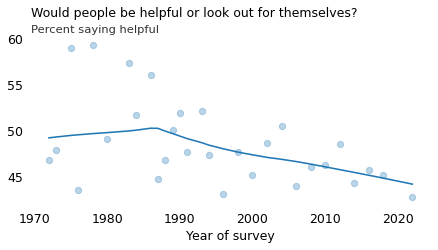

<IPython.core.display.Javascript object>

In [113]:
plot_by_year(varname, selected_value)

In [109]:
from utils import prepare_yvar
from utils import chunk_series


def plot_by_cohort(yvarname, yvalue):
    xvarname = "cohort"

    prepare_yvar(gss, yvarname, yvalue)
    by_cohort = chunk_series(gss, xvarname, size=600) * 100

    plot_series_lowess(
        by_cohort,
        plot_series=True,
        color="C1",
        ls="dashed",
        label="",
    )

    decorate(
        xlabel="Year of birth",
        ylim=ylim,
    )
    plot_titles(title, subtitle)

<IPython.core.display.Javascript object>

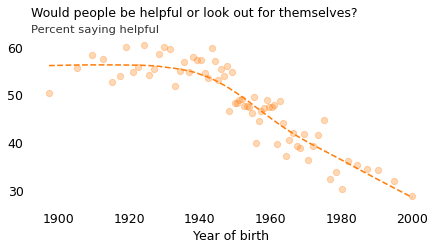

<IPython.core.display.Javascript object>

In [110]:
plot_by_cohort(varname, selected_value)

In [114]:
from utils import make_table

xvarname = "year"
gvarname = "cohort10"

prepare_yvar(gss, varname, selected_value)

subset = gss.dropna(subset=["cohort10"]).copy()
subset["cohort10"] = subset["cohort10"].astype(int)
table = make_table(subset, xvarname, varname, gvarname, yvalue)
del table[1890]
del table[1900]

<IPython.core.display.Javascript object>

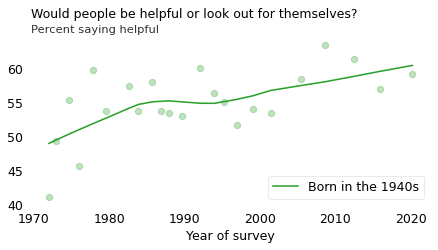

<IPython.core.display.Javascript object>

In [115]:
plot_series_lowess(table[1940], plot_series=True, color="C2", label="Born in the 1940s")

plot_titles(title, subtitle)
decorate(
    xlabel="Year of survey",
    ylim=ylim,
    loc='lower right'
)


In [105]:
from utils import get_colors
from utils import label_table


def visualize_table(table, nudge={}, **options):
    """Plot the results from make_table.

    table: map from group name to Series
    options: passed to plot
    """
    palette = options.pop("palette", "Purples")
    colors = get_colors(len(table), palette=palette)

    for i, series in enumerate(table.values()):
        label = f"{series.name}s"
        plot_series_lowess(
            series, color=colors[i], label=label, plot_series=False, **options
        )
    label_table(table, nudge)

    plot_titles(title, subtitle)
    decorate(
        xlabel="Year of survey",
        ylim=ylim,
        legend=False,
    )


<IPython.core.display.Javascript object>

(25.033897788631915, 70.66783136683462)

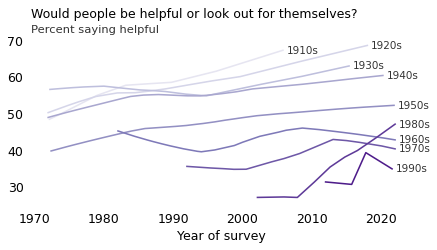

<IPython.core.display.Javascript object>

In [116]:
visualize_table(table)

Copyright 2024 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).